# Excess mortality in different countries during the COVID-19 pandemics

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib

from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
import datetime
import statsmodels.api as sm

In [2]:
import math

def round_to_n(x, n):
    if x==0:
        return 0
    if np.isnan(x):
        return np.nan
    else:
        return round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [3]:
df = pd.read_csv('https://github.com/akarlinsky/world_mortality/blob/main/world_mortality.csv?raw=true')

df_population = pd.read_csv('https://github.com/datasets/population/blob/master/data/population.csv?raw=true')

df_official = pd.read_csv('https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv?raw=true')

In [4]:
# print(np.sum(df[(df['country_name']=='Peru')&(df['year']==2017)]['deaths']))
# print(np.sum(df[(df['country_name']=='Peru')&(df['year']==2018)]['deaths']))
# print(np.sum(df[(df['country_name']=='Peru')&(df['year']==2019)]['deaths']))
# print(np.sum(df[(df['country_name']=='Peru')&(df['year']==2020)]['deaths']))

In [5]:
# from urllib.request import Request, urlopen  # Python 3
# req = Request('http://covid.ourworldindata.org/data/owid-covid-data.csv?raw=true')
# req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
# content = urlopen(req)
# df_official = pd.read_csv(content)

In [6]:
# Week of the first official covid19 death, to start the excess mortality calculation

def get_excess_begin(country, datapoints_per_year = 53):
#     if country=='Hong Kong':  # Very few deaths, but part of China
#         return 1
#     if country=='Macao':      # No deaths at all, but part of China
#         return 1
#     if country=='Mauritius':  # Fewer than 10 official deaths
#         return 3  
#     if country=='Mongolia':   # Fewer than 10 official deaths
#         return 3 
#     if country=='Taiwan':     # Fewer than 10 official deaths
#         return 3 
    if country=='Bolivia':    # April is missing
        return 3  # For Bolivia this means May, because April is missing
        
    mm = {'Bosnia':'Bosnia and Herzegovina'}
    country_lookup = country if country not in mm else mm[country]
    
    if datapoints_per_year > 12:
        d = df_official[(df_official['location']==country_lookup) 
                      & (df_official['total_deaths']>0)]['date'].values[0]
        beg = datetime.date(2020, int(d[5:7]), int(d[8:10])).isocalendar()[1]
    
    elif datapoints_per_year == 12:
#         d = df_official[(df_official['location']==country_lookup) 
#                       & (df_official['total_deaths']>10)]['date'].values[0]
#         if int(d[8:10]) > 25:
#             beg = int(d[5:7]) + 1
#         else:
#             beg = int(d[5:7])
#         beg -= 1
        beg = 2  # March
        
    elif datapoints_per_year == 4:
        beg = 0 
        
    return beg

In [7]:
def predict(X, country, verbose=False):    
    # Fit regression model on pre-2020 data 
    ind = (X[:,0] < 2020) & (X[:,1]<53)
    m = np.max(X[ind,1])
    onehot = np.zeros((np.sum(ind), m))
    for i,k in enumerate(X[ind,1]):
        onehot[i,k-1] = 1
    predictors = np.concatenate((X[ind,:1], onehot), axis=1)
    reg = LinearRegression(fit_intercept=False).fit(predictors, X[ind,2])
    
    if verbose:
        est = sm.OLS(X[ind,2], predictors)
        est = est.fit()
        print(est.summary())
    
    # Compute 2020 baseline
    ind2 = X[:,0] == 2020
    predictors2020 = np.concatenate((np.ones((m,1))*2020, np.eye(m)), axis=1)
    baseline = reg.predict(predictors2020)
            
    # Week 53 usually does not have enough data, so we'll use 
    # the same baseline value as for week 52
    if np.max(X[:,1])==53:
        baseline = np.concatenate((baseline, [baseline[-1]]))
        
    # for Ireland week 1 is missing for unclear reason
    if np.min(X[ind,1])==2:
        baseline[0] = baseline[1]
    
    # Excess mortality
    ind2 = X[:,0] == 2020
    diff2020 = X[ind2,2] - baseline[X[ind2,1]-1]
    ind3 = X[:,0] == 2021
    diff2021 = X[ind3,2] - baseline[X[ind3,1]-1]
    excess_begin = get_excess_begin(country, baseline.size)
    total_excess = np.sum(diff2020[excess_begin:]) + np.sum(diff2021)
        
    # Manual fit for uncertainty computation
    if np.unique(X[ind,0]).size > 1:
        y = X[ind,2][:,np.newaxis]
        beta = np.linalg.pinv(predictors.T @ predictors) @ predictors.T @ y
        yhat = predictors @ beta
        sigma2 = np.sum((y-yhat)**2) / (y.size-predictors.shape[1])
        
        S = np.linalg.pinv(predictors.T @ predictors)
        w = np.zeros((m, 1))
        w[X[(X[:,0] == 2020) & (X[:,1] < 53),1]-1] = 1
        if np.max(X[:,1])==53:
            w[52-1] += 1
        w[:excess_begin] = 0
        w[X[ind3,1]-1] += 1
        
        if country=='Ireland':
            w[1] += w[0]
            w[0] = 0 
        
        p = 0
        for i,ww in enumerate(w):
            p += predictors2020[i] * ww
        p = p[:,np.newaxis]
                        
        predictive_var = sigma2 * np.sum(w) + sigma2 * p.T @ S @ p
        total_excess_std = np.sqrt(predictive_var)[0][0]
    else:
        total_excess_std = np.nan
       
    return baseline, total_excess, excess_begin, total_excess_std

In [8]:
countries = np.unique(df['country_name'])
print(countries.size, '\n')

allcountries = {}

for i, country in enumerate(countries):    
    print(country, end=', ' if i<countries.size-1 else '')
    if (i+1)%6 == 0:
        print('')
        
    assert(np.unique(df[(df['country_name']==country)]['time_unit']).size == 1)
    
    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
    
#     if country == 'Russia':
#         X = np.concatenate((X, [[2020,12,243235]]))
    
#     if country=='Ireland':
#         X = X[X[:,0]>=2018,:]

#     if country=='Peru':
#         X = X[X[:,0]>=2018,:]
        
    baseline, total_excess, excess_begin, total_excess_std = predict(X, country)
        
    # https://en.wikipedia.org/wiki/Casualties_of_the_2020_Nagorno-Karabakh_war
    if country=='Armenia':
        total_excess -= 4000 # 3360
    if country=='Azerbaijan':
        total_excess -= 4000 # (2854+50)
        
    # August 2020 heatwave, weeks 32-34
    # 1539, 1583, 35, 660, 3688
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany']:
        heatwave = np.sum(X[(X[:,0]==2020)&(X[:,1]>=32)&(X[:,1]<=34), 2])
        heatwave -= np.sum(baseline[32-1:34+1-1])
        total_excess -= heatwave
        print(f'*-{heatwave:.0f}*, ', end='')

    allcountries[country] = [X, baseline, total_excess, excess_begin, total_excess_std]

81 

Albania, Armenia, Australia, Austria, Azerbaijan, Belarus, 
Belgium, *-1540*, Bolivia, Bosnia, Brazil, Bulgaria, Canada, 
Chile, Colombia, Costa Rica, Croatia, Cyprus, Czechia, 
Denmark, Ecuador, Egypt, Estonia, Finland, France, 
*-1585*, Georgia, Germany, *-3705*, Greece, Hong Kong, Hungary, Iceland, 
Iran, Ireland, Israel, Italy, Japan, Kazakhstan, 
Kosovo, Kyrgyzstan, Latvia, Liechtenstein, Lithuania, Luxembourg, 
*-35*, Macao, Malaysia, Malta, Mauritius, Mexico, Moldova, 
Mongolia, Montenegro, Netherlands, *-660*, New Zealand, North Macedonia, Norway, 
Oman, Peru, Philippines, Poland, Portugal, Qatar, 
Romania, Russia, San Marino, Serbia, Singapore, Slovakia, 
Slovenia, South Africa, South Korea, Spain, Sweden, Switzerland, 
Taiwan, Tajikistan, Thailand, Tunisia, Ukraine, United Kingdom, 
United States, Uruguay, Uzbekistan

In [9]:
# X = allcountries['Peru'][0]
# print(np.sum(X[X[:,0]==2017,2]))
# print(np.sum(X[X[:,0]==2018,2]))
# print(np.sum(X[X[:,0]==2019,2]))
# # (214-126)/126

# # np.sum(allcountries['Peru'][1])

In [10]:
# heatwave

1537+1579+3680+35+660

7491

In [11]:
# Export the baselines

with open('baselines.csv','w') as f:
    for c in allcountries:
        X, baseline, total_excess, excess_begin, total_excess_std = allcountries[c] 
        for i,b in enumerate(baseline):
            f.write(f'{c}, {i+1}, {b:.1f}\n')

In [12]:
# # 2021 data present

# for c in allcountries:
#     if allcountries[c][0][-1][0]==2021:
#         print(c)

In [13]:
# Population

mm = {'South Korea':'Korea, Rep.',
      'Slovakia':'Slovak Republic',
      'Russia':'Russian Federation',
      'Iran':'Iran, Islamic Rep.',
      'Czechia':'Czech Republic',
      'Egypt':'Egypt, Arab Rep.',
      'Hong Kong':'Hong Kong SAR, China',
      'Bosnia':'Bosnia and Herzegovina',
      'Kyrgyzstan':'Kyrgyz Republic',
      'Macao':'Macao SAR, China'}

pops = np.zeros(len(allcountries.keys()))
for i,m in enumerate(allcountries.keys()):
    # Russia's population should include Crimea because mortality figures do 
    # Ukraine's population should *not* include Crimea
    if m=='Russia':
        pops[i] = 146748590 # Rosstat, estimate for 1 Jan 2020    
    if m=='Ukraine':
        pops[i] = 41762138 # Ukrstat 2020, according to Wikipedia
    elif m in mm:
        pops[i] = df_population[df_population['Country Name']==mm[m]]['Value'].values[-1]
    elif m=='Taiwan':
        pops[i] = 23568378 # Wikipedia 
    else:
        pops[i] = df_population[df_population['Country Name']==m]['Value'].values[-1]

In [14]:
# Daily reported numbers during the same time period

mm = {'Bosnia':'Bosnia and Herzegovina'}

official = np.zeros(len(allcountries.keys()))
officialnow = np.zeros(len(allcountries.keys()))

for i,m in enumerate(allcountries.keys()):
    howmany = np.max(allcountries[m][0][:,1])
    last = allcountries[m][0][-1][1]
    lastyear = allcountries[m][0][-1][0]
    
    if howmany > 12:
        d = f'{lastyear}-W{last:02}'
        r = datetime.datetime.strptime(d + '-0', "%G-W%V-%w")
        r = str(r)[:10]
    elif howmany == 12:
        if m=='Brazil': # !!!!!!!!!!!!!TEMPORARY FIX!!!!!!!!!!!!!!!!!
            r = f'{lastyear}-{last:02}-31' 
        elif last < 12:
            r = f'{lastyear}-{last+1:02}-01'
        else:
            r = f'{lastyear+1}-01-01'
    elif howmany == 4:
        if m == 'Iran':
            # https://twitter.com/Mahan_Ghafari/status/1336338070249951236
            r = '2020-09-21'
        else:
            if last < 4:
                r = f'{lastyear}-{last*3+1:02}-01'
            else:
                r = f'{lastyear+1}-01-01'
    else:
        r = ''
        
    if m == 'Hong Kong':
        official[i] = 109 # December 1, 2020 #np.nan
        #https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
        continue
        
    if m == 'Macao':
        official[i] = 0
        continue
    
    if m in mm:
        official[i] = df_official[(df_official['location']==mm[m])
                                  &(df_official['date']==r)]['total_deaths'].values[0]
        officialnow[i] = df_official[(df_official['location']==mm[m])]['total_deaths'].values[-1]
    else:
        official[i] = df_official[(df_official['location']==m)
                                  &(df_official['date']==r)]['total_deaths'].values[0]
        officialnow[i] = df_official[(df_official['location']==m)]['total_deaths'].values[-1]

In [15]:
print(np.nansum(official))

c = 0
for m in allcountries:
    c += allcountries[m][2]
print(c)

print(c - np.nansum(official))
print(c / np.nansum(official))

1733476.0
2619446.19020458
885970.1902045798
1.511094581179422


In [16]:
count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if z>2 and allcountries[c][2]>0:
        count += 1
print(count)      

count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if z>2 and allcountries[c][2]<0:
        count += 1
print(count)   

count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if z<2:
        count += 1
print(count)   

count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z):
        count += 1
print(count)   

56
7
16
2


In [17]:
count = 0
for c in allcountries:
    if allcountries[c][1].size > 12:
        count += 1
print(count)

count = 0
for c in allcountries:
    if allcountries[c][1].size == 12:
        count += 1
print(count)

count = 0
for c in allcountries:
    if allcountries[c][1].size == 4:
        count += 1
print(count)

48
30
3


In [18]:
# ex = []
# for m in mega:
#     ex.append(np.sum(mega[m][2][excess_begin(m):]))
# ex = np.array(ex)

# plt.figure(figsize=(4,4))
# plt.scatter(ex/pops * 100, ex/official)
# plt.ylim([0,15])
# plt.xlim([0,.3])
# sns.despine()
# plt.tight_layout()

In [19]:
# def smooth(country, w=2):
#     X, pred, diff, diff21 = mega[country]
#     X_smoothed = []
#     pred_smoothed = []
#     for y in range(X[0,0], X[-1,0]+1):
#         for t in range(1, np.max(X[:,1]), w):
#             ind = (X[:,0]==y) & (X[:,1]>=t) & (X[:,1]<t+w)
#             X_smoothed.append([y, int((t-1)/w+1), np.sum(X[ind,2])])
#     for t in range(0, pred.size, w):
#         pred_smoothed.append(np.sum(pred[t:t+w]))            
#     X_smoothed = np.array(X_smoothed)
#     pred_smoothed = np.array(pred_smoothed)
#     mega[country] = [X_smoothed, pred_smoothed, diff, diff21]
    
# smooth('Liechtenstein', 4)

<IPython.core.display.Javascript object>


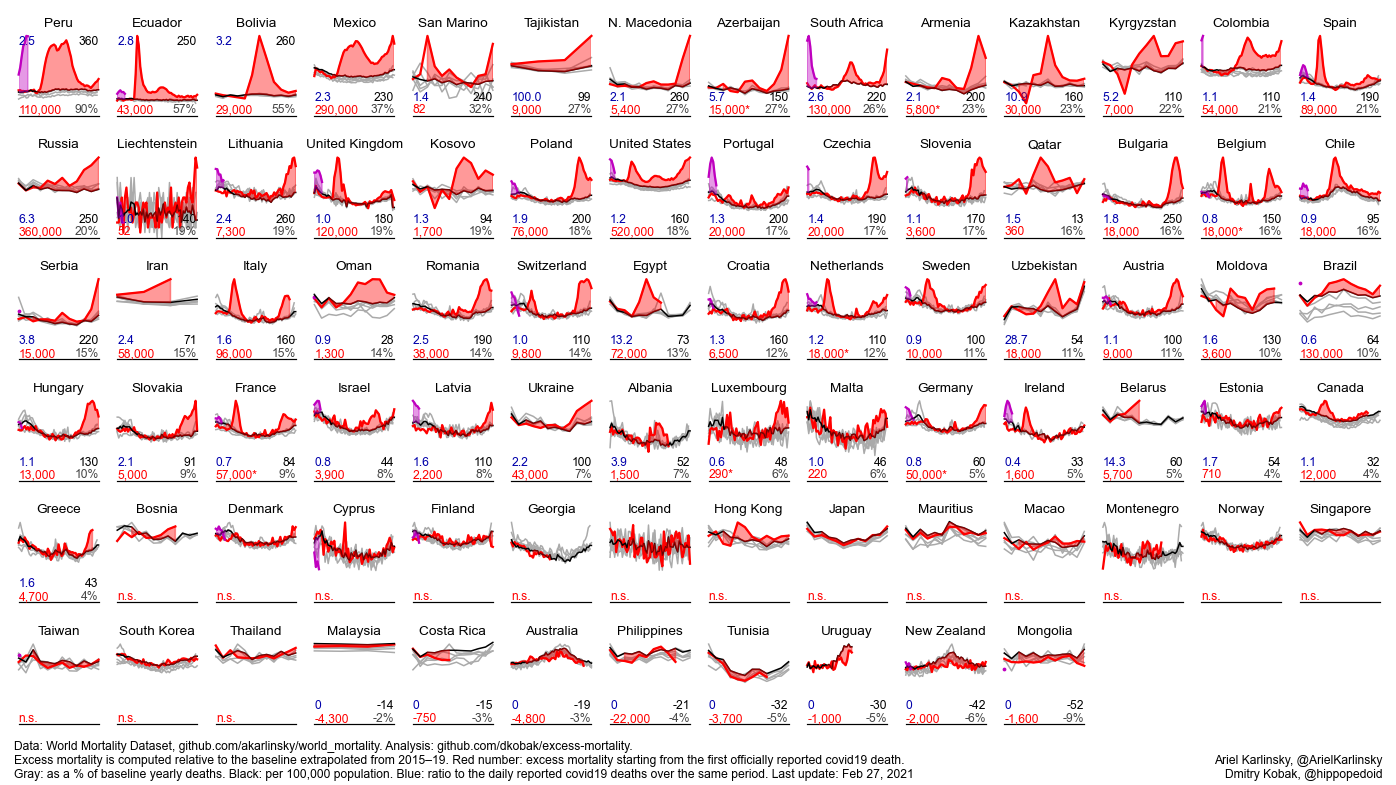

In [20]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    d = total_excess/np.sum(baseline)*100
    if np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000
    ds[i] = d
ind = np.argsort(ds)[::-1]

fig = plt.figure(figsize=(8*1.6,4.5*1.6))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
    plt.subplot(6,14,i+1)
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
    plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
    if np.sum(X[:,0]==2021)>1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], color='m', lw=1.5, clip_on=False)
    elif np.sum(X[:,0]==2021)==1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color='m', markersize=3, clip_on=False)
    plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

    if i>=3: #np.max(X[:,-1]) < np.mean(baseline) * 2.75:
        toplabel = .3
    else:
        toplabel = 1
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    thresh = 2
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
        plt.text(.0, .03, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, .03, f'{total_excess/np.sum(baseline)*100:.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[ind][i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if total_excess>0:
            plt.text(.0, toplabel, f'{total_excess/official[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '0', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, .03, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    poly1 = np.concatenate((X[X[:,0]==2020, 1][excess_begin:], X[X[:,0]==2020, 1][excess_begin:][::-1]))
    poly2 = np.concatenate((X[X[:,0]==2020, 2][excess_begin:], baseline[X[X[:,0]==2020, 1]-1][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor='r', edgecolor='r', alpha=.4, zorder=5)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021)>1:
        poly1 = np.concatenate((X[X[:,0]==2021, 1], X[X[:,0]==2021, 1][::-1]))
        poly2 = np.concatenate((X[X[:,0]==2021, 2], baseline[X[X[:,0]==2021, 1]-1][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor='m', edgecolor='m', alpha=.4, zorder=5)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,np.nanmax(X[:,-1])])
#     plt.ylim([0,2*np.mean(baseline)])
    plt.xlim([1, baseline.size])
    
    # For Uruguay:
    if baseline.size > 12 and baseline.size < 50:
        plt.xlim([1,53])
        
    plt.xticks([])
    plt.yticks([])
    plt.title(country if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=9)
        
sns.despine(left=True)
plt.tight_layout(rect=(0,.05,1,1))

fig.text(.01,.005, 
'Data: World Mortality Dataset, github.com/akarlinsky/world_mortality. '
'Analysis: github.com/dkobak/excess-mortality.\n'
'Excess mortality is computed relative to the baseline extrapolated from 2015–19. '
'Red number: excess mortality starting from the first officially reported covid19 death.\n'
'Gray: as a % of baseline yearly deaths. '
'Black: per 100,000 population. '
'Blue: ratio to the daily reported covid19 deaths over the same period. '
f'Last update: {datetime.date.today():%b %d, %Y}', fontsize=8, va='bottom')

fig.text(.99,.005, 'Ariel Karlinsky, @ArielKarlinsky\nDmitry Kobak, @hippopedoid', 
         fontsize=8, ha='right', va='bottom')

plt.savefig('img/all-countries.png', dpi=200)

In [21]:
continents = {'East Europe':['Albania','Belarus','Bosnia','Bulgaria','Croatia','Cyprus','Czechia',
                             'Estonia','Greece','Hungary','Kosovo','Latvia','Lithuania','Moldova',
                             'Montenegro','North Macedonia','Poland','Romania', 'Russia','Serbia',
                             'Slovakia', 'Slovenia','Ukraine',],
              'West Europe':['Austria','Belgium','Denmark','Finland','France','Germany',
                             'Iceland','Ireland','Italy','Liechtenstein','Luxembourg',
                             'Malta','Netherlands','Norway','Portugal','San Marino',
                             'Spain', 'Sweden', 'Switzerland','United Kingdom',],
              'Asia':['Hong Kong','Japan','Macao', 'Malaysia','Mongolia','Philippines','Singapore',
                      'South Korea','Taiwan','Thailand',],
              'Oceania':['Australia','New Zealand',],
              'Middle East Central Asia':['Armenia','Azerbaijan','Egypt','Georgia','Iran',
                                          'Israel','Kazakhstan','Kyrgyzstan','Oman','Qatar',
                                          'Tajikistan','Uzbekistan'],
              'Africa':['Mauritius','South Africa','Tunisia',],
              'Latin America':['Bolivia','Brazil','Chile','Colombia','Costa Rica','Ecuador',
                               'Mexico','Peru','Uruguay',],
              'North America':['Canada','United States',],}

country2continent = {}
for c in continents:
    for cc in continents[c]:
        country2continent[cc] = c
        
continent_colors = {'East Europe':'#1b9e77',
              'West Europe':'#d95f02',
              'Asia':'#7570b3',
              'Oceania':'#e7298a',
              'Middle East Central Asia':'#66a61e',
              'Africa':'#e6ab02',
              'Latin America':'#a6761d',
              'North America':'#666666'}

<IPython.core.display.Javascript object>


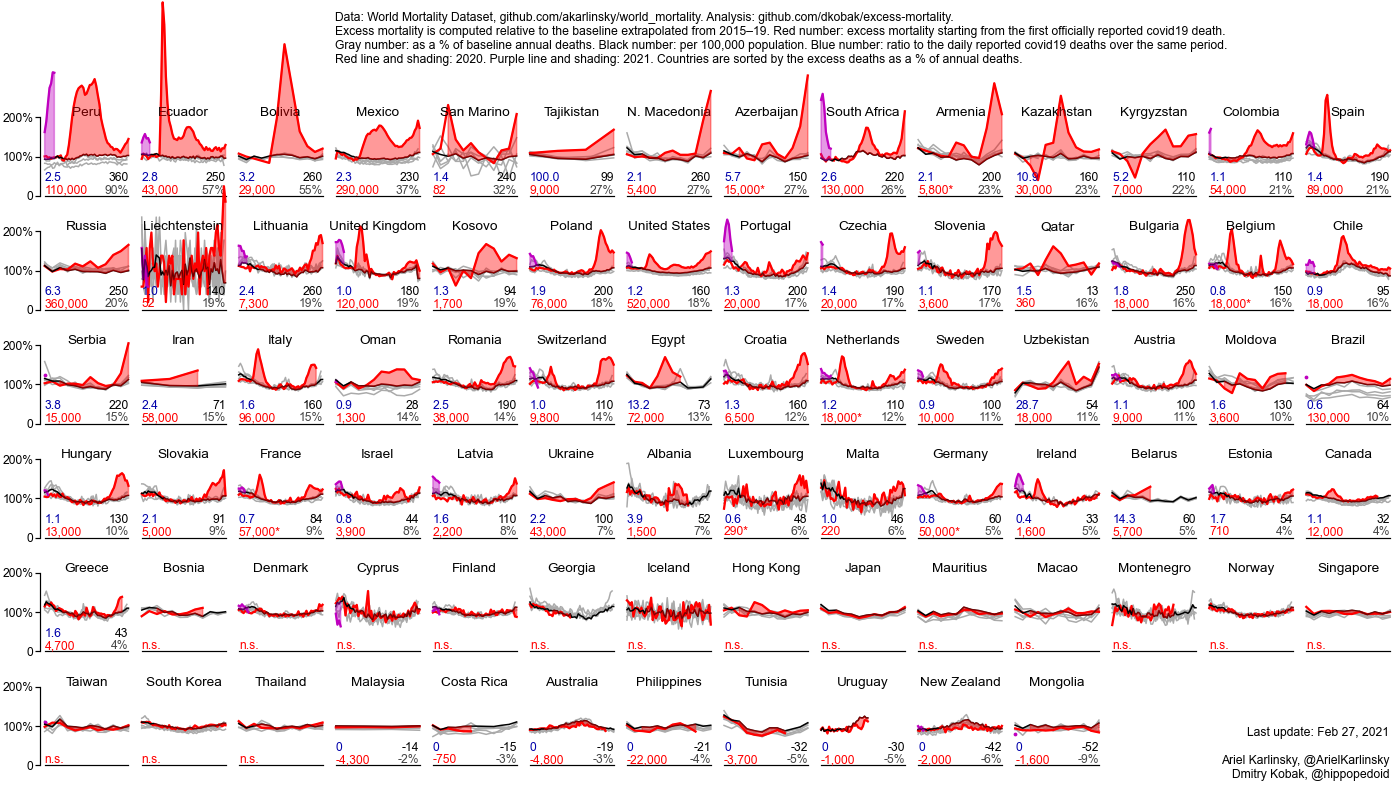

In [22]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    d = total_excess/np.sum(baseline)*100
    if np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000
    ds[i] = d
ind = np.argsort(ds)[::-1]

fig = plt.figure(figsize=(8*1.6,4.5*1.6))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
#     plt.subplot(6,14,i+1)
    ax = plt.axes([.032+(i%14)*.0695, .75-np.floor(i/14)*.145, .06, .1])
    
    col2020 = 'r' #continent_colors[country2continent[country]]  # 'r'
    col2021 = 'm' #continent_colors[country2continent[country]]  # 'm'
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
    plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color=col2020, lw=1.5, clip_on=False)
    if np.sum(X[:,0]==2021)>1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], color=col2021, lw=1.5, clip_on=False)
    elif np.sum(X[:,0]==2021)==1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color=col2021, markersize=3, clip_on=False)
    plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

#     if i>=3: #np.max(X[:,-1]) < np.mean(baseline) * 2.75:
    toplabel = .3
#     else:
#         toplabel = 1
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    thresh = 2
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
        plt.text(.0, .03, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, .03, f'{total_excess/np.sum(baseline)*100:.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[ind][i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if total_excess>0:
            plt.text(.0, toplabel, f'{total_excess/official[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '0', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, .03, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    poly1 = np.concatenate((X[X[:,0]==2020, 1][excess_begin:], X[X[:,0]==2020, 1][excess_begin:][::-1]))
    poly2 = np.concatenate((X[X[:,0]==2020, 2][excess_begin:], baseline[X[X[:,0]==2020, 1]-1][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=.4, zorder=5, clip_on=False)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021)>1:
        poly1 = np.concatenate((X[X[:,0]==2021, 1], X[X[:,0]==2021, 1][::-1]))
        poly2 = np.concatenate((X[X[:,0]==2021, 2], baseline[X[X[:,0]==2021, 1]-1][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor=col2021, edgecolor=col2021, alpha=.4, zorder=5, clip_on=False)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,2*np.mean(baseline)])
    plt.xlim([1, baseline.size])
    plt.xticks([])
    
    # For Uruguay:
    if baseline.size > 12 and baseline.size < 50:
        plt.xlim([1,53])
        
    plt.title(country if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=9, y=.9)
        
    if i%14 > 0:
        plt.yticks([])
        sns.despine(left=True, ax=ax)
    else:
        plt.yticks([0,np.mean(baseline),np.mean(baseline)*2], ['0', '100%', '200%'], fontsize=7)
        sns.despine(ax=ax, offset={'left':3})
        plt.gca().set_yticklabels(['0', '100%', '200%'], fontsize=8)
        plt.gca().yaxis.set_tick_params(pad=1)

# plt.tight_layout(rect=(0,.05,1,1))

# from matplotlib import font_manager as fm
# myfont = fm.FontProperties(fname='fonts/static/EBGaramond-Regular.ttf')
# fig.text(.32,.93, 'Excess mortality during Covid-19', fontproperties=myfont, fontsize=28)

fig.text(.24, .915, 
'Data: World Mortality Dataset, github.com/akarlinsky/world_mortality. '
'Analysis: github.com/dkobak/excess-mortality.\n'
'Excess mortality is computed relative to the baseline extrapolated from 2015–19. '
'Red number: excess mortality starting from the first officially reported covid19 death.\n'
'Gray number: as a % of baseline annual deaths. '
'Black number: per 100,000 population. '
'Blue number: ratio to the daily reported covid19 deaths over the same period.\n'
'Red line and shading: 2020. Purple line and shading: 2021. Countries are sorted '
'by the excess deaths as a % of annual deaths.',
         fontsize=8, va='bottom')

fig.text(.995,.005, f'Last update: {datetime.date.today():%b %d, %Y}\n\n'
         'Ariel Karlinsky, @ArielKarlinsky\nDmitry Kobak, @hippopedoid', 
         fontsize=8, ha='right', va='bottom')


plt.savefig('img/all-countries-fixedscale.png', dpi=200)

In [23]:
def until_date(country):
    howmany = np.max(allcountries[country][0][:,1])
    last = allcountries[country][0][-1][1]
    lastyear = allcountries[country][0][-1][0]

    if howmany>12:
        date = datetime.datetime.strptime(f'{lastyear}-W{last:02}-0', "%G-W%V-%w")
    elif howmany==12:
        if last<12:
            date = datetime.datetime.strptime(f'{lastyear}-{last+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
    else:
        if last<4:
            date = datetime.datetime.strptime(f'{lastyear}-{last*3+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
        
        if country=='Iran':
            if last>1:
                date = datetime.datetime.strptime(f'{lastyear}-{last*3:02}-21', "%Y-%m-%d")
            else:
                date = datetime.datetime.strptime(f'{lastyear-1}-12-21', "%Y-%m-%d")

    date = date.strftime('%b %d, %Y')
    
    if howmany>12:
        time_format = 'w'
    elif howmany==12:
        time_format = 'm'
    else:
        time_format = 'q'
    
    return date, time_format
    

print('Country                     Until  Type   Confirmed      Excess      std      t  Undercount  Per 100k   Increase')
print('----------------------------------------------------------------------------------------------------------------')

for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 2
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        undercount = f'        {round_to_n(np.max((0,allcountries[c][2]))/official[i],2):4.1f}' 
        per100k    = f'      {round_to_n(allcountries[c][2]/pops[i]*1e+5,2):4.0f}'
        increase   = f'        {allcountries[c][2]/np.sum(allcountries[c][1])*100:2.0f}%'

    else:
        undercount = ''
        per100k    = ''
        increase   = ''
    
    print(f'{c:20} {until:15}  {time_format}     {round_to_n(official[i],2):7,.0f}'
          f'     {round_to_n(allcountries[c][2],2):7,.0f} ± {round_to_n(allcountries[c][4],2):6,.0f}' 
          f'  {z:5.1f}' + undercount + per100k + increase)

Country                     Until  Type   Confirmed      Excess      std      t  Undercount  Per 100k   Increase
----------------------------------------------------------------------------------------------------------------
Albania              Sep 27, 2020     w         380       1,500 ±    350    4.3         3.9        52         7%
Armenia              Dec 31, 2020     m       2,800       5,800 ±    650    9.0         2.1       200        23%
Australia            Nov 22, 2020     w         910      -4,800 ±    810    6.0         0.0       -19        -3%
Austria              Feb 14, 2021     w       8,200       9,000 ±  1,100    8.4         1.1       100        11%
Azerbaijan           Dec 31, 2020     m       2,700      15,000 ±  1,300   11.7         5.7       150        27%
Belarus              Jun 30, 2020     m         400       5,700 ±    930    6.1        14.0        60         5%
Belgium              Feb 14, 2021     w      22,000      18,000 ±  1,400   12.4         0.8     

In [24]:
for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 2
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        undercount = f'{round_to_n(np.max((0,allcountries[c][2]))/official[i],2):.1f}' 
        per100k    = f'${round_to_n(allcountries[c][2]/pops[i]*1e+5,2):.0f}$'
        increase   = f'${allcountries[c][2]/np.sum(allcountries[c][1])*100:.0f}\%$'

    else:
        undercount = 'n.s.'
        per100k    = 'n.s.'
        increase   = 'n.s.'
        
    minus = '$-$' if allcountries[c][2]<0 else ''
    
    print(f'{c} & {until} & {time_format} & {round_to_n(official[i],2):,.0f} & '
          '' + minus + f'{round_to_n(np.abs(allcountries[c][2]),2):,.0f}'
          f'& $\pm\,${round_to_n(allcountries[c][4],2):,.0f} & ' 
          f'{z:.1f}' + ' & ' + undercount + ' & '  + per100k + ''
          ' & ' + increase + '\\\\')

Albania & Sep 27, 2020 & w & 380 & 1,500& $\pm\,$350 & 4.3 & 3.9 & $52$ & $7\%$\\
Armenia & Dec 31, 2020 & m & 2,800 & 5,800& $\pm\,$650 & 9.0 & 2.1 & $200$ & $23\%$\\
Australia & Nov 22, 2020 & w & 910 & $-$4,800& $\pm\,$810 & 6.0 & 0.0 & $-19$ & $-3\%$\\
Austria & Feb 14, 2021 & w & 8,200 & 9,000& $\pm\,$1,100 & 8.4 & 1.1 & $100$ & $11\%$\\
Azerbaijan & Dec 31, 2020 & m & 2,700 & 15,000& $\pm\,$1,300 & 11.7 & 5.7 & $150$ & $27\%$\\
Belarus & Jun 30, 2020 & m & 400 & 5,700& $\pm\,$930 & 6.1 & 14.0 & $60$ & $5\%$\\
Belgium & Feb 14, 2021 & w & 22,000 & 18,000& $\pm\,$1,400 & 12.4 & 0.8 & $150$ & $16\%$\\
Bolivia & Dec 31, 2020 & m & 9,200 & 29,000& $\pm\,$640 & 45.7 & 3.2 & $260$ & $55\%$\\
Bosnia & Sep 30, 2020 & m & 860 & 670& $\pm\,$710 & 0.9 & n.s. & n.s. & n.s.\\
Brazil & Jan 31, 2021 & m & 220,000 & 130,000& $\pm\,$22,000 & 6.1 & 0.6 & $64$ & $10\%$\\
Bulgaria & Feb 14, 2021 & w & 9,600 & 18,000& $\pm\,$1,400 & 12.8 & 1.8 & $250$ & $16\%$\\
Canada & Nov 08, 2020 & w & 11,000 & 12

In [25]:
# Export the table

with open('excess-mortality.csv','w') as f:
    f.write('Country,Data until,Data type,COVID-19 deaths,Excess deaths,'
            'Excess deaths std,t-statistic,Undercount ratio,Excess per 100k,'
            'Excess as % of annual baseline\n')
    
    for i,c in enumerate(allcountries):
        until, time_format = until_date(c)
         
        if official[i] > 0:
            undercount = np.max((0,allcountries[c][2]))/official[i]
        else:
            undercount = 0
        per100k    = allcountries[c][2]/pops[i]*1e+5
        increase   = allcountries[c][2]/np.sum(allcountries[c][1])*100
        
        z = np.abs(allcountries[c][2])/allcountries[c][4]
        if z < 2:
            undercount = np.nan
            per100k = np.nan
            increase = np.nan
            
        f.write(f'{c},"{until}",{time_format},{official[i]:.0f},{allcountries[c][2]:.0f},'
                f'{allcountries[c][4]:.0f},{z:.1f},{undercount:.2f},{per100k:.1f},{increase:.1f}\n')

<IPython.core.display.Javascript object>


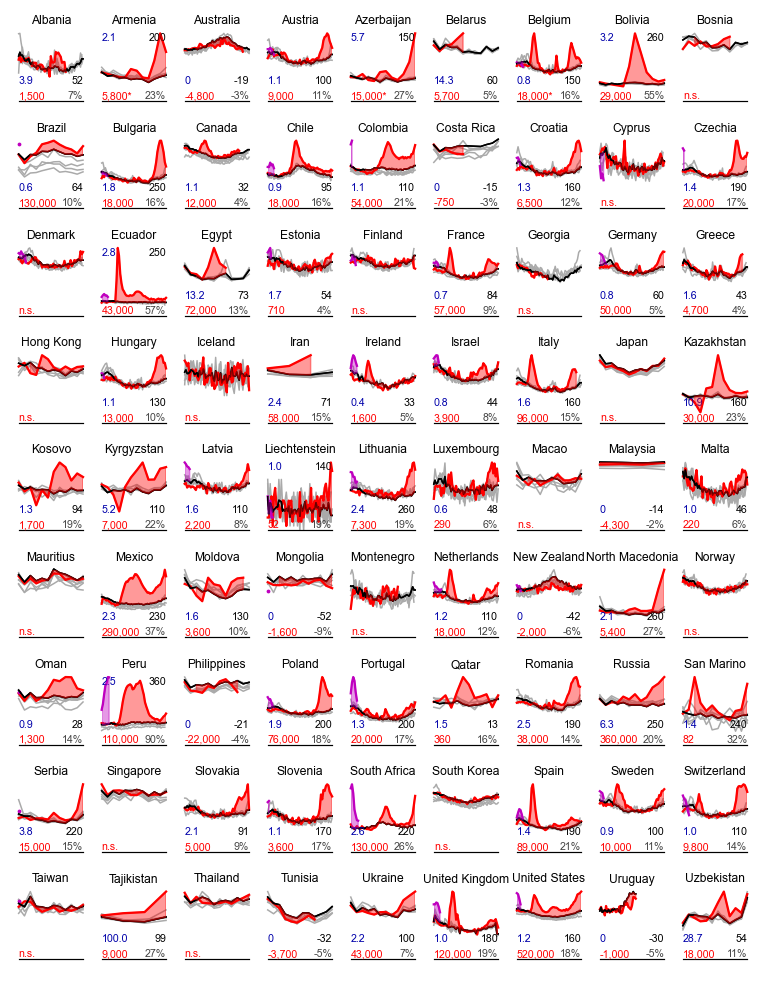

In [26]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(7,9))

for i,country in enumerate(allcountries.keys()):
    plt.subplot(9,9,i+1)
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
    plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
    if np.sum(X[:,0]==2021)>1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], color='m', lw=1.5, clip_on=False)
    elif np.sum(X[:,0]==2021)==1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color='m', markersize=3, clip_on=False)
    plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

    plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

    if np.max(X[:,-1]) < np.mean(baseline) * 2.75:
        toplabel = .37
    else:
        toplabel = 1
        
    if country in ['Belgium','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 7
    thresh = 2
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
#         if np.abs(total_excess)>100000:
#             plt.text(.0, .03, f'{np.round(total_excess/1000)*1000:,.0f}'+star, transform=plt.gca().transAxes,
#                      color='r', fontsize=fs)
#         elif np.abs(total_excess)>1000:
#             plt.text(.0, .03, f'{np.round(total_excess/100)*100:,.0f}'+star, transform=plt.gca().transAxes,
#                      color='r', fontsize=fs)
#         else:
        plt.text(.0, .03, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, .03, f'{total_excess/np.sum(baseline)*100:.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if total_excess>0:
            plt.text(.0, toplabel, f'{total_excess/official[i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '0', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, .03, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    poly1 = np.concatenate((X[X[:,0]==2020, 1][excess_begin:], X[X[:,0]==2020, 1][excess_begin:][::-1]))
    poly2 = np.concatenate((X[X[:,0]==2020, 2][excess_begin:], baseline[X[X[:,0]==2020, 1]-1][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor='r', edgecolor='r', alpha=.4, zorder=5)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021)>1:
        poly1 = np.concatenate((X[X[:,0]==2021, 1], X[X[:,0]==2021, 1][::-1]))
        poly2 = np.concatenate((X[X[:,0]==2021, 2], baseline[X[X[:,0]==2021, 1]-1][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor='m', edgecolor='m', alpha=.4, zorder=5)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,np.nanmax(X[:,-1])])
    plt.xlim([1, baseline.size])
    
    # For Uruguay:
    if baseline.size > 12 and baseline.size < 50:
        plt.xlim([1,53])
        
    plt.xticks([])
    plt.yticks([])
    plt.title(country,# if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=8)
        
sns.despine(left=True)
plt.tight_layout()

plt.savefig('img/all-countries-a4.pdf')

In [27]:
# # Placeholder to look stuff up

# country = 'Sweden'

# X,baseline,_,_,_ = allcountries[country] 
# plt.figure(figsize=(5,3))
# for year in np.arange(X[0,0],2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1)
# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
# plt.plot(X[X[:,0]==2020, 1][get_excess_begin('Sweden'):], 
#          X[X[:,0]==2020, 2][get_excess_begin('Sweden'):], '.', color='r', lw=1.5, clip_on=False)
# plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1)

# for year in np.arange(X[0,0],2021):
#     print(np.sum(X[X[:,0]==year, 2]))

# # beg = excess_begin(country)
# # d = np.sum(diff[10:21])
# # d

# plt.title('Sweden')

# sns.despine()
# plt.tight_layout()
# plt.savefig('img/swe.png', dpi=100)

# # (X[X[:,0]==2020, 2] - baseline)

In [28]:
# X = allcountries['Belgium'][0]
# baseline = allcountries['Belgium'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# # a = 0
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)
# #     a+=X[(X[:,0]==year)&(X[:,1]<53), 2]
# # a/=5

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2020, 1], baseline,'k' )    
# # plt.plot(X[X[:,0]==2020, 1], a, 'k--' )    
# plt.legend()

# np.sum(X[X[:,0]==2020, 2][31:34] - baseline[31:34])

In [29]:
# df = pd.read_csv('https://github.com/Financial-Times/coronavirus-excess-mortality-data/blob/master/data/ft_excess_deaths.csv?raw=true')
# X = df[(df['region']=='New York City')&(df['year']>=2015)][['year','week','deaths']].values

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1)
# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=1.5, clip_on=False)
# plt.xlim([1,53])
# plt.ylim([0,8000])
# plt.title('New York City')
# plt.xlabel('Week')
# plt.ylabel('Deaths per week')
# sns.despine()
# plt.tight_layout()

# print(np.sum(X[X[:,0]==2020, 2][10:25]-X[X[:,0]==2019, 2][10:25]))

# plt.savefig('img/nyc.png', dpi=100)

In [30]:
# X = allcountries['Ireland'][0]
# baseline = allcountries['Ireland'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2020)
# plt.plot(X[X[:,0]==2020, 1], baseline,'k' )    
# plt.legend()

# print(np.sum(X[X[:,0]==2020, 2][11:21] - baseline[11:21]))
# print(np.sum(X[X[:,0]==2020, 2][11:] - baseline[11:]))
# print(np.sum(X[X[:,0]==2021, 2][:3] - baseline[:3]))

In [31]:
# X = allcountries['Italy'][0]
# baseline = allcountries['Italy'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2020)
# plt.plot(np.arange(baseline.size)+1, baseline,'k' )    
# plt.legend()

In [32]:
# X = allcountries['Sweden'][0]
# baseline = allcountries['Sweden'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2021)
# plt.plot(np.arange(baseline.size)+1, baseline,'k' )    
# plt.legend()

# plt.ylabel('Weekly deaths')
# plt.ylim([0,2600])
# plt.title('Sweden')
# sns.despine()
# plt.tight_layout()
# plt.savefig('img/swe.png', dpi=100)

In [33]:
# X = allcountries['Bolivia'][0]
# baseline = allcountries['Bolivia'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2021)
# plt.plot(np.arange(baseline.size)+1, baseline,'k' )    
# plt.legend()

# np.sum(X[X[:,0]==2020, 2][3:]) - np.sum(baseline[4:])

In [34]:
# X = allcountries['France'][0]
# baseline = allcountries['France'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2021)
# plt.plot(np.arange(baseline.size)+1, baseline,'k' )    
# plt.legend()

In [35]:
# X = allcountries['Peru'][0]
# baseline = allcountries['Peru'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2021)
# plt.plot(np.arange(baseline.size)+1, baseline,'k', label='model')    
# plt.legend()

# sns.despine()
# plt.tight_layout()
# plt.savefig('img/peru2.png',dpi=100)

<IPython.core.display.Javascript object>


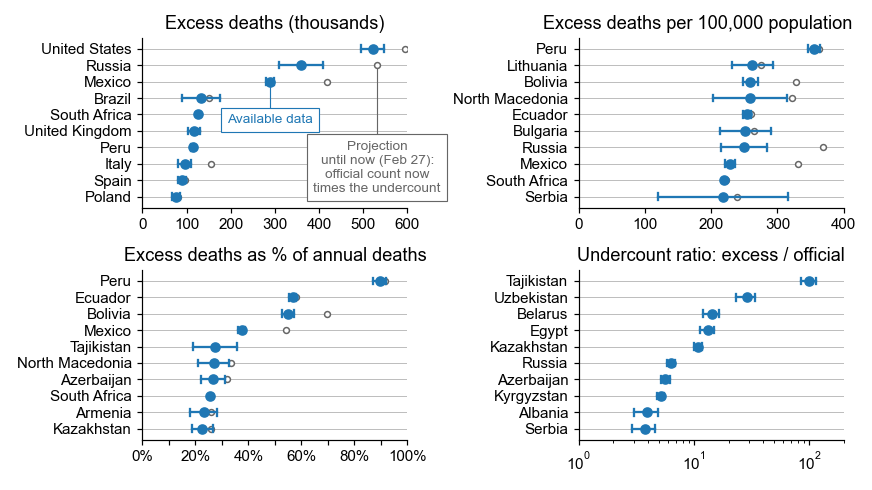

In [36]:
d = df_official[df_official['location']==country]['total_deaths'].values

plt.figure(figsize=(8, 4.5))

plt.subplot(221)

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / 1000
    z[i] = allcountries[c][4] / 1000 * 1.96
    y[i] = x[i] / (official[i]+.001) * officialnow[i]
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
plt.scatter(y[ind],-np.arange(10), c='w', edgecolors='#666666', zorder=.5, s=15)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [0,600] # plt.xlim()
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600])
plt.title('Excess deaths (thousands)')

plt.text(y[ind][1],-8.7, f'Projection\nuntil now ({datetime.date.today():%b %d}):\n'
                         'official count now\ntimes the undercount', color='#666666', 
         fontsize=9, ha='center', bbox=dict(facecolor='w', edgecolor='#666666', lw=.75))
plt.plot([y[ind][1],y[ind][1]], [-8,-1], lw=.75, color='#666666',zorder=.1)
plt.text(x[ind][2],-4.5, 'Available data', color=sc.get_facecolors()[0], 
         fontsize=9, ha='center', bbox=dict(facecolor='w', edgecolor=sc.get_facecolors()[0], lw=.75))
plt.plot([x[ind][2],x[ind][2]], [-5,-2], lw=.75, color=sc.get_facecolors()[0],zorder=.1)

plt.subplot(224)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / (official[i]+.001)
    z[i] = allcountries[c][4] / (official[i]+.001)
    if allcountries[c][2]/allcountries[c][4] < 2:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [1,200] # plt.xlim()
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.title('Undercount ratio: excess / official')
plt.xscale('log')

plt.subplot(222)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / pops[i] * 1e+5
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    z[i] = allcountries[c][4] / pops[i] * 1e+5 * 1.96
    if pops[i] < 50000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
plt.scatter(y[ind],-np.arange(10), c='w', edgecolors='#666666', zorder=.5, s=15)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [0,400]
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400])
plt.title('Excess deaths per 100,000 population', x=.45)

plt.subplot(223)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / np.sum(allcountries[c][1]) * 100
    z[i] = allcountries[c][4] / np.sum(allcountries[c][1]) * 100 * 1.96
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    if pops[i] < 50000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
plt.scatter(y[ind],-np.arange(10), c='w', edgecolors='#666666', zorder=.5, s=15)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [0,100] # plt.xlim()
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100],
           ['0%','','20%','','40%','','60%','','80%','','100%'])
plt.title('Excess deaths as % of annual deaths')

sns.despine()
plt.tight_layout()

plt.savefig('img/leaderboard.png', dpi=200)

In [37]:
# Until the end of 2020

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))

for i,c in enumerate(allcountries):
    d = allcountries[c][0][allcountries[c][0][:,0]==2020,2]
    b = allcountries[c][1]
    if d.size == b.size:
        x[i] = np.sum(d-b) / pops[i] * 1e+5
        y[i] = x[i]
        
    if c=='Armenia':
        y[i] -= 4000 / pops[i] * 1e+5
    if c=='Azerbaijan':
        y[i] -= 4000 / pops[i] * 1e+5
    if c=='Belgium':
        y[i] -= 1539 / pops[i] * 1e+5
    
    z[i] = y[i]
    if pops[i] < 50000:
        z[i] = 0

# ind = np.argsort(x)[::-1][:20]
# for i in ind:
#     c = np.array(list(allcountries.keys()))[i]
#     print(f'{c:15} {x[i]:.0f}')
# print('')

# ind = np.argsort(y)[::-1][:20]
# for i in ind:
#     c = np.array(list(allcountries.keys()))[i]
#     print(f'{c:15} {y[i]:.0f}')
# print('')

ind = np.argsort(z)[::-1][:20]
for i in ind:
    c = np.array(list(allcountries.keys()))[i]
    print(f'{c:15} {z[i]:.0f}')

Peru            274
Russia          248
North Macedonia 241
Bulgaria        235
Ecuador         229
Mexico          219
Armenia         204
Lithuania       197
Serbia          193
Kazakhstan      164
Poland          160
Spain           155
Czechia         151
Azerbaijan      150
Slovenia        148
Belgium         142
United States   138
Croatia         132
South Africa    122
United Kingdom  121


## Extrapolation until today

In [38]:
countries = np.unique(df_official['location'])
stoplist = ['World','Europe','North America','European Union','South America','Asia','Africa']
countries = np.array([c for c in countries if c not in stoplist])
deaths = np.zeros(countries.size)
for i,country in enumerate(countries):
    d = df_official[df_official['location']==country]['total_deaths'].values
    if np.sum(~np.isnan(d)) > 0:
        deaths[i] = np.nanmax(d)
deaths[np.isnan(deaths)]=0
ind = np.argsort(deaths)[::-1][:30]
countries = countries[ind]
deaths = deaths[ind]

df_mine = pd.read_csv('excess-mortality.csv', index_col=None)

undercounts = np.zeros(30) * np.nan
for i,c in enumerate(countries):
    if c in df_mine['Country'].values:
        undercounts[i] = df_mine[df_mine['Country']==c]['Undercount ratio'].values[0]
        
mm = {'South Korea':'Korea, Rep.',
      'Slovakia':'Slovak Republic',
      'Russia':'Russian Federation',
      'Iran':'Iran, Islamic Rep.',
      'Czechia':'Czech Republic',
      'Egypt':'Egypt, Arab Rep.',
      'Hong Kong':'Hong Kong SAR, China',
      'Bosnia':'Bosnia and Herzegovina',
      'Kyrgyzstan':'Kyrgyz Republic',
      'Macao':'Macao SAR, China'}        

populations = np.zeros(30) * np.nan
for i,c in enumerate(countries):
#     if c in df_population['Country Name'].values:
    populations[i] = df_population[df_population['Country Name']==(mm[c] if c in mm else c)]['Value'].values[-1] / 1e+6
        
    if c=='Russia':
        populations[i] = 146.8

In [39]:
data = [[countries[i],deaths[i],undercounts[i],populations[i]] for i in range(countries.size)]

df = pd.DataFrame(data, columns=['Country', 'Covid19 deaths, now', 
                                 'Underreporting (excess deaths / covid19 deaths)', 
                                 'Population (mln)'])

df['Estimated deaths'] = np.maximum(df['Underreporting (excess deaths / covid19 deaths)'],1) * df['Covid19 deaths, now']
df['Estimated deaths per 100,000'] = df['Estimated deaths'] / df['Population (mln)'] / 10

In [40]:
df

,Country,"Covid19 deaths, now",Underreporting (excess deaths / covid19 deaths),Population (mln),Estimated deaths,"Estimated deaths per 100,000"
0,United States,510458.0,1.16,326.687501,592131.28,181.253117
1,Brazil,252835.0,0.59,209.469333,252835.00,120.702633
2,Mexico,184474.0,2.27,126.190788,418755.98,331.843542
3,India,156938.0,NaN,1352.617328,NaN,NaN
4,United Kingdom,122648.0,1.00,66.460344,122648.00,184.543131
5,Italy,97227.0,1.59,60.421760,154590.93,255.853073
6,France,85738.0,0.71,66.977107,85738.00,128.010904
7,Russia,83900.0,6.34,146.800000,531926.00,362.347411
8,Germany,69939.0,0.76,82.905782,69939.00,84.359617
9,Spain,69142.0,1.38,46.796540,95415.96,203.895331


<IPython.core.display.Javascript object>


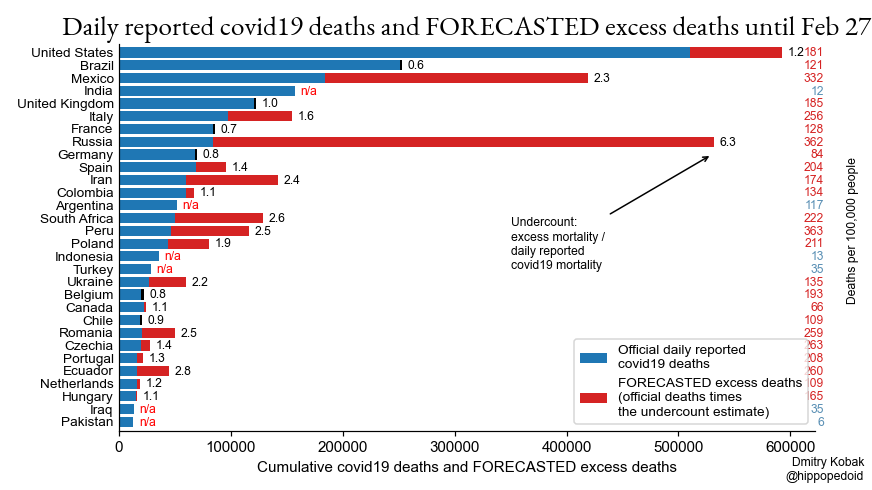

In [41]:
from matplotlib import font_manager as fm
myfont = fm.FontProperties(fname='fonts/static/EBGaramond-Regular.ttf')

fig = plt.figure(figsize=(8, 4.5))

plt.barh(-np.arange(df.shape[0]), df['Covid19 deaths, now'], label='Official daily reported\ncovid19 deaths')
delta = df['Estimated deaths'] - df['Covid19 deaths, now']
delta[delta<0] = 0
plt.barh(-np.arange(df.shape[0]), delta, left=df['Covid19 deaths, now'], color='#d52323',
         label='FORECASTED excess deaths\n(official deaths times\nthe undercount estimate)')
         
plt.yticks(-np.arange(df.shape[0]), [a for a in df['Country']], fontsize=9)
plt.xlabel('Cumulative covid19 deaths and FORECASTED excess deaths')

for i in np.where(delta==0)[0]:
    plt.barh(-i, 2000, left=np.array(df['Covid19 deaths, now'])[i]-2000, color='k')
for i in np.where(np.isnan(delta))[0]:
    plt.text(np.array(df['Covid19 deaths, now'])[i] + 5000, -i-.3, 'n/a', color='r', fontsize=8)
for i in range(df.shape[0]):
    if np.isnan(df['Estimated deaths'].values[i]):
        plt.text(630000, -i-.3, 
             f"{df['Covid19 deaths, now'].values[i]/df['Population (mln)'].values[i]/10:.0f}",
             color='#598fb4', ha='right', fontsize=8)
        continue
    plt.text(df['Estimated deaths'].values[i] + 5000, -i-.3, 
             f"{df['Underreporting (excess deaths / covid19 deaths)'].values[i]:.1f}",
             color='k', fontsize=8)
    plt.text(630000, -i-.3, 
             f"{df['Estimated deaths per 100,000'].values[i]:.0f}",
             color='#d52323', ha='right', fontsize=8)
    
plt.title(f'Daily reported covid19 deaths and FORECASTED excess deaths until {datetime.date.today():%b %d}', 
          fontproperties=myfont, fontsize=18)

plt.gca().tick_params(axis='y', length=0)

plt.gca().annotate('Undercount:\nexcess mortality /\ndaily reported\ncovid19 mortality',
                   xy=(530000, -8), xycoords='data',
                   xytext=(350000, -17), textcoords='data',
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                   fontsize=8)

plt.text(650000,-14,'Deaths per 100,000 people', rotation=90, va='center', fontsize=8)

plt.ylim([-df.shape[0]+.3,.7])
# plt.xlim([0,370000])

sns.despine()
plt.tight_layout()

plt.legend(loc='lower right', fontsize=9)

fig.text(.99,.02, 'Dmitry Kobak\n@hippopedoid', size=8, ha='right')

plt.savefig('img/countries.png', dpi=200)